## Looks at "Value" from the Value Model

### Setup

In [2]:
# Try to decode which feature was selected per-trial based on firing rates of neurons
# experiment with ranges of firing rates around fixation (selection) time

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import pickle

from models.value_model import ValueModel
from models.model_wrapper import ModelWrapper

from models.trainer import Trainer

import torch

matplotlib.rcParams['figure.dpi'] = 150


species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 

feature_dims = ["Color", "Shape", "Pattern"]

pre_interval = 1300
post_interval = 1500

In [3]:
# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   
shuffled_card_idxs = behavioral_utils.get_shuffled_card_idxs(valid_beh)

In [4]:
firing_rates = pd.read_pickle(fs.open("l2l.pqz317.scratch/firing_rates_1300_fb_1500_100_bins.pickle"))

### Train Model with all the trial data

0.6963979416809606


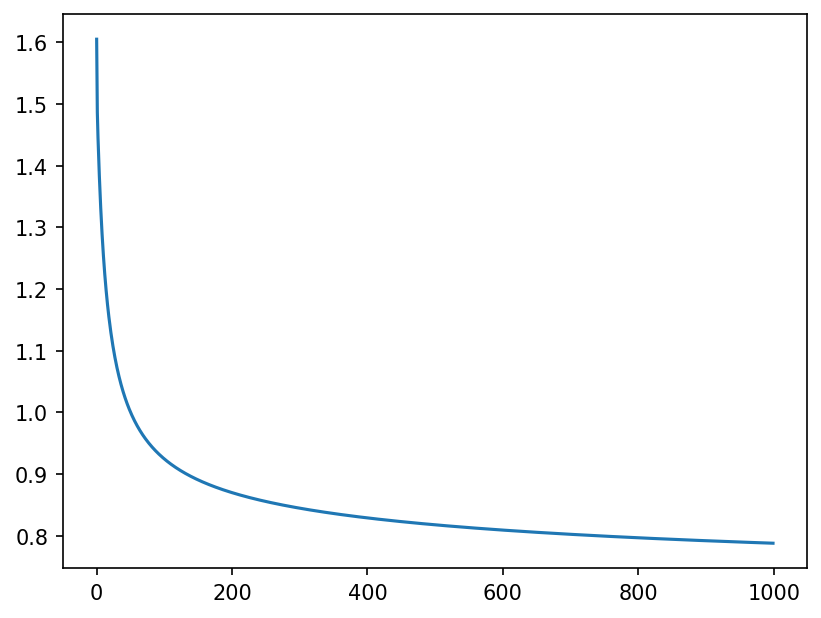

In [9]:
pre_interval = 1300
post_interval = 1500
device = "cuda" if torch.cuda.is_available() else "cpu"


num_neurons = len(firing_rates.UnitID.unique())
labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
init_params = {"n_inputs": num_neurons, "n_values": 12}
trainer = Trainer(learning_rate=0.1, max_iter=1000)
model = ValueModel(**init_params)

mode = "SpikeCounts"

# prep data for classification
inputs = firing_rates.rename(columns={mode: "Value"})
# just look at one time bin
# look at 0.6 because that should be where decodabilty is highest
inputs = inputs[np.isclose(inputs["TimeBins"], 0.6)]
labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

x_train = classifier_utils.transform_to_input_data(inputs)
cards_train = classifier_utils.transform_cards_or_none(shuffled_card_idxs)
y_train = classifier_utils.transform_to_label_data(labels)

possible_labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
labels_to_idx = {label: idx for idx, label in enumerate(possible_labels)}
y_train_idxs = np.array([labels_to_idx[label] for label in y_train.tolist()]).astype(int)

losses = trainer.train(model, x_train, y_train_idxs, cards_train)

x = torch.Tensor(x_train).to(device)
cards = torch.Tensor(cards_train).to(torch.long).to(device)

probs = model(x, cards)
label_idxs = np.argmax(probs.detach().cpu().numpy(), axis=1)
train_acc = np.sum(label_idxs == y_train_idxs) / len(y_train_idxs)

print(train_acc)

fig, ax = plt.subplots()
ax.plot(losses)

### Register hook on "Feature Value" layer

### Find Block, Plot Relative Value of Rule by Trial

In [25]:
# choose block number as 1
# rule as CYAN

values = {}
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.linear.register_forward_hook(get_activation("linear"))

trial_numbers = valid_beh[valid_beh.BlockNumber == 1].TrialNumber.unique()
for trial in trial_numbers: 
    # prep data for classification
    inputs = firing_rates.rename(columns={mode: "Value"})
    # just look at one time bin
    # look at 0.6 because that should be where decodabilty is highest
    inputs = inputs[np.isclose(inputs["TimeBins"], 0.6)]
    labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

    x = classifier_utils.transform_to_input_data(inputs, trials_filter=np.array([trial]))
    cards = classifier_utils.transform_cards_or_none(shuffled_card_idxs, trials_filter=np.array([trial]))
    
    x = torch.Tensor(x).to(device)
    cards = torch.Tensor(cards).to(torch.long).to(device)
    res = model(x, cards)
    values[trial] = activation["linear"]

print(values)

{8: tensor([[-0.9846, -2.1702,  3.7382, -2.4436, -0.3907,  0.0125,  0.1960, -0.1719,
          0.5273, -0.9516,  2.2921, -2.4666]], device='cuda:0'), 9: tensor([[-1.7503, -2.2149, -0.8020,  1.6206, -2.4468,  0.9260, -2.1656,  1.1076,
          0.0756, -2.1520,  1.9963, -0.1880]], device='cuda:0'), 10: tensor([[ 0.5611,  0.3978, -0.2445, -1.3145,  0.0244,  1.3749, -0.9411,  1.0021,
          0.3798, -2.4536,  1.0939, -0.0480]], device='cuda:0'), 11: tensor([[-0.4590, -1.1121, -1.1249,  0.7136, -0.4820, -0.1221, -0.6591, -0.1447,
         -0.3030,  0.2524,  0.7341, -1.1467]], device='cuda:0'), 12: tensor([[-1.0534, -0.8973,  1.1300, -0.1598,  0.4182, -0.6392, -0.2317, -0.7186,
         -0.0926,  0.2358,  0.5580, -1.1320]], device='cuda:0'), 13: tensor([[-0.2437, -0.3503, -0.9079,  0.6770, -0.3075, -0.1710, -1.7371, -1.3900,
         -0.2572, -0.4330, -0.0488,  0.6591]], device='cuda:0'), 14: tensor([[-1.3010, -0.4152, -0.7629,  0.3417, -1.4466,  0.5359, -1.8377,  0.9715,
          0.6510

In [14]:
valid_beh[valid_beh.BlockNumber == 1]

,TrialNumber,BlockNumber,TrialAfterRuleChange,TaskInterrupt,ConditionNumber,Response,ItemChosen,TrialType,CurrentRule,LastRule,...,Item0Pattern,Item1Shape,Item1Color,Item1Pattern,Item2Shape,Item2Color,Item2Pattern,Item3Shape,Item3Color,Item3Pattern
8,8,1,0,NaN,2690,Incorrect,3.0,4,CYAN,RIPPLE,...,ESCHER,TRIANGLE,MAGENTA,SWIRL,SQUARE,YELLOW,POLKADOT,CIRCLE,GREEN,RIPPLE
9,9,1,1,NaN,2620,Incorrect,2.0,4,CYAN,RIPPLE,...,POLKADOT,TRIANGLE,MAGENTA,ESCHER,SQUARE,YELLOW,RIPPLE,CIRCLE,GREEN,SWIRL
10,10,1,2,NaN,2419,Incorrect,2.0,4,CYAN,RIPPLE,...,SWIRL,SQUARE,MAGENTA,ESCHER,CIRCLE,YELLOW,RIPPLE,STAR,GREEN,POLKADOT
11,11,1,3,NaN,2407,Incorrect,3.0,4,CYAN,RIPPLE,...,ESCHER,CIRCLE,MAGENTA,SWIRL,STAR,YELLOW,RIPPLE,SQUARE,GREEN,POLKADOT
12,12,1,4,NaN,2375,Correct,0.0,4,CYAN,RIPPLE,...,RIPPLE,CIRCLE,MAGENTA,POLKADOT,STAR,YELLOW,SWIRL,SQUARE,GREEN,ESCHER
13,13,1,5,NaN,2666,Correct,0.0,4,CYAN,RIPPLE,...,ESCHER,SQUARE,MAGENTA,SWIRL,CIRCLE,YELLOW,POLKADOT,TRIANGLE,GREEN,RIPPLE
14,14,1,6,NaN,2810,Incorrect,3.0,4,CYAN,RIPPLE,...,ESCHER,STAR,MAGENTA,SWIRL,CIRCLE,YELLOW,POLKADOT,TRIANGLE,GREEN,RIPPLE
15,15,1,7,NaN,2370,Correct,0.0,4,CYAN,RIPPLE,...,RIPPLE,CIRCLE,MAGENTA,POLKADOT,SQUARE,YELLOW,ESCHER,STAR,GREEN,SWIRL
16,16,1,8,NaN,2749,Correct,0.0,4,CYAN,RIPPLE,...,POLKADOT,CIRCLE,MAGENTA,SWIRL,STAR,YELLOW,ESCHER,TRIANGLE,GREEN,RIPPLE
17,17,1,9,NaN,2613,Correct,0.0,4,CYAN,RIPPLE,...,POLKADOT,CIRCLE,MAGENTA,ESCHER,TRIANGLE,YELLOW,SWIRL,SQUARE,GREEN,RIPPLE
